<a href="https://colab.research.google.com/github/ebenajayi/Predictive_Modeling/blob/main/Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Read Data





In [ ]:
#remove annoying exp overflow warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2)

bk_data = pd.read_csv('/content/bankrupcy.csv') #bankrupcy data
bk_data = bk_data.iloc[np.random.permutation(bk_data.index)].reset_index(drop=True)

hp_data = pd.read_csv('/content/hepatitis.csv') #hepatitis data
hp_data = hp_data.iloc[np.random.permutation(hp_data.index)].reset_index(drop=True)

FileNotFoundError: ignored

#Data Preprocessing Functions

###Remove Excess (Highly Coorelated) Features

In [ ]:
def cor_featurelist(dframe):
  feature_list = []
  for i in range(len(dframe.columns)):
      for j in range(i):
          if abs(dframe.iloc[i, j]) > 0.99:
            if not (dframe.columns[i] in feature_list):
              feature_list.append(dframe.columns[i])
  return feature_list

###Remove Outliers

In [ ]:
def remove_outliers(X, y, n = 3):
  for i in range(X.shape[1]):
    if(len(np.unique(X[:,i])) == 2):
      continue
    data_mean, data_std = np.mean(X[:,i]), np.std(X[:,i])
    cut_off = data_std * n
    lower, upper = data_mean - cut_off, data_mean + cut_off
    outliers = [index for index, value in enumerate(X[:,i]) if value < lower or value > upper]
    X = np.delete(X, outliers, 0)
    y = np.delete(y, outliers, 0)
  return X, y

# Logistic Regression Class

In [ ]:
'''
Logistic Regression Classifier
Parameters
-------------------------------
Basic
-------------------------------
lr : 
	Learning Rate : default = 0.01
threshold :
	Stopping threshold for gradient descent : default = 1e-4
max_iter :
	Maximum number of descent steps before stopping : default = 100000
----------
reg : 
	Regularization to be used : 'l1', 'l2' or None, default='None'
penalty : 
	Regularization penalty to be used : default=0

-------------------------------
Advanced
-------------------------------
lr_schedule :
	LR Scheduling technique to be used: 'time' or 'step', default = 'time'
----------
For Time based:
----------
lr_decay :
	LR decay over time: default = 0 i.e no decay
----------
For Step based:
----------
lr_drop
	LR drop over given interval: default = 0.5
lr_nstep
	Step interval to drop LR over: default = 0.5
----------
'''
class LogisticRegression:
  def __init__(self, lr=0.01, lr_schedule='time', lr_decay=0, lr_drop=0.5, interval=10, reg='None', penalty=0, threshold=1e-4, max_iter=100000, verbose=False):
    self.lr = lr
    self.reg = reg
    self.verbose = verbose
    self.penalty = penalty
    self.lr_decay = lr_decay
    self.lr_schedule = lr_schedule
    self.drop = lr_drop
    self.interval = interval
    self.threshold = threshold
    self.max_iter = max_iter

  def __sigmoid(self, x):
    return 1/(1 + np.exp(-x))

  def __updatelr(self, x, i):
    if(self.lr_schedule == 'step'):
      return self.lr * (self.drop**np.floor((1+i)/(self.interval)))
    else:
      return x * 1./(1. + self.lr_decay * i)

  def __regularizer(self):
    if(self.reg == 'l1'):
      return np.concatenate(([0], self.penalty * np.sign(self.weights[1:])), axis=0)
    elif(self.reg == 'l2'):
      return np.concatenate(([0], 2 * self.penalty * self.weights[1:]), axis=0)
    else:
      return 0

  def fit(self, X, y):
    self.weights = np.zeros(X.shape[1] + 1)                                              # initialize weights
    X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)                            # add 1 for biases i.e. [1, x1, x2, x3, ...]
    lr = self.lr

    loss = np.ones(X.shape[1] + 1)  
    n_iter = 0

    while(np.any(abs(loss) > self.threshold) and n_iter < self.max_iter):
      y_pred = self.__sigmoid(np.dot(X, self.weights))
      loss = lr * ((np.dot(X.T , (y_pred - y)) / len(X))) + self.__regularizer()         # loss function (the first part is being normalized to prevent loss explosion with more data)
      self.weights -= loss
      lr = self.__updatelr(lr, n_iter)
      n_iter = n_iter + 1
      if(self.verbose == True and i % 1000 == 0):
        print(f"Accuracy = {accu_eval(y, np.round(y_pred))}")
    return

  def predict_prob(self, X):
    return self.__sigmoid(np.array(np.dot(X, self.weights[1:]) + self.weights[0], dtype=np.float128))

  def predict(self, X):
    return np.round(self.predict_prob(X))


#Evaluation Functions

In [ ]:
def accu_eval(y_true, y_pred):
  return (y_true == y_pred).mean()

In [ ]:
from sklearn.metrics import roc_auc_score

def k_crossval(model, X, y, k=10, verbose=True, scale=False, rm_out=False):
  mean_acc = 0
  mean_auc = 0
  for i in range(k):
    p = int(len(X)/k)
    train_X, train_y = np.delete(X, np.s_[i*p:i*p+p], axis=0), np.delete(y, np.s_[i*p:i*p+p], axis=0)
    val_X, val_y = X[i*p:i*p+p], y[i*p:i*p+p]

    if(rm_out):
      train_X, train_y = remove_outliers(train_X, train_y)

    if(scale):
      mean, std =  np.mean(train_X, axis=0), np.std(train_X, axis=0)
      train_X = (train_X - mean) / std
      val_X = (val_X - mean) / std

    model.fit(train_X, train_y)
    acc_t = accu_eval(train_y, model.predict(train_X))
    acc_v = accu_eval(val_y, model.predict(val_X))
    auc_v = roc_auc_score(val_y, model.predict_prob(val_X))
    if(verbose): 
      print(f"Cross val iter {i}, Train Accuracy = {acc_t}, Validation Accuracy = {acc_v}, AUC = {auc_v}")
    mean_acc += acc_v/k
    mean_auc += auc_v/k
  print(f"Mean over {k} folds: Validation Accuracy  = {mean_acc}, AUC = {mean_auc}")
  return [mean_acc, mean_auc]

#Hepatitis Dataset




###Load Data

In [ ]:
hp_correlation_matrix = hp_data[:-1].corr()
hp_drop_features = cor_featurelist(hp_correlation_matrix)
hp_data.drop(labels=hp_drop_features, axis=1, inplace=True)

hp_data_array = np.array(hp_data.values)

X = hp_data_array[:,:-1]
y = hp_data_array[:,-1]

for i in range(X.shape[1]):
  if(len(np.unique(X[:,i])) == 2):
    continue
  X[:,i] = np.sqrt(X[:,i])

### Basic Model

In [ ]:
basic = LogisticRegression(lr=0.05, threshold=1e-5, verbose=False)
k_crossval(basic, X, y, k=10)

Cross val iter 0, Train Accuracy = 0.875, Validation Accuracy = 0.7857142857142857, AUC = 0.5
Cross val iter 1, Train Accuracy = 0.828125, Validation Accuracy = 0.7857142857142857, AUC = 0.9333333333333333
Cross val iter 2, Train Accuracy = 0.8203125, Validation Accuracy = 0.8571428571428571, AUC = 1.0
Cross val iter 3, Train Accuracy = 0.59375, Validation Accuracy = 0.42857142857142855, AUC = 0.9166666666666667
Cross val iter 4, Train Accuracy = 0.9375, Validation Accuracy = 0.6428571428571429, AUC = 0.5151515151515151
Cross val iter 5, Train Accuracy = 0.8671875, Validation Accuracy = 0.8571428571428571, AUC = 0.8333333333333334
Cross val iter 6, Train Accuracy = 0.8828125, Validation Accuracy = 0.8571428571428571, AUC = 0.8181818181818182
Cross val iter 7, Train Accuracy = 0.7421875, Validation Accuracy = 0.6428571428571429, AUC = 0.5384615384615384
Cross val iter 8, Train Accuracy = 0.875, Validation Accuracy = 0.7857142857142857, AUC = 0.8333333333333334
Cross val iter 9, Train Ac

[0.7357142857142858, 0.7763461538461539]

### Scaling Data

In [ ]:
scaled = LogisticRegression(lr=6.1585E-5, threshold=1e-5, verbose=False)
k_crossval(scaled, X, y, k=10, scale=True)

Cross val iter 0, Train Accuracy = 0.859375, Validation Accuracy = 0.9285714285714286, AUC = 0.9393939393939394
Cross val iter 1, Train Accuracy = 0.8515625, Validation Accuracy = 0.8571428571428571, AUC = 0.9777777777777779
Cross val iter 2, Train Accuracy = 0.875, Validation Accuracy = 0.8571428571428571, AUC = 0.9230769230769231
Cross val iter 3, Train Accuracy = 0.859375, Validation Accuracy = 0.8571428571428571, AUC = 0.875
Cross val iter 4, Train Accuracy = 0.890625, Validation Accuracy = 0.7142857142857143, AUC = 0.6060606060606061
Cross val iter 5, Train Accuracy = 0.8515625, Validation Accuracy = 0.9285714285714286, AUC = 1.0
Cross val iter 6, Train Accuracy = 0.8828125, Validation Accuracy = 0.7857142857142857, AUC = 0.7272727272727273
Cross val iter 7, Train Accuracy = 0.8515625, Validation Accuracy = 0.9285714285714286, AUC = 0.9230769230769231
Cross val iter 8, Train Accuracy = 0.8671875, Validation Accuracy = 0.7857142857142857, AUC = 0.9393939393939394
Cross val iter 9, 

[0.8428571428571427, 0.8744386169386171]

####Explore Learning Rate



In [ ]:
hp_lr_exploration = []
space = 1/np.geomspace(1, 100000, num=20)

generate = False
if generate:
  for i in range(len(space)):
    explore = LogisticRegression(lr=space[i], threshold=1e-5, verbose=False)
    hp_lr_exploration.append((k_crossval(explore, X, y, k=10, verbose=False, scale=True)))
  np.save('/content/hp_lr_exploration.npy', hp_lr_exploration)
else:
  hp_lr_exploration = np.load('/content/hp_lr_exploration.npy')

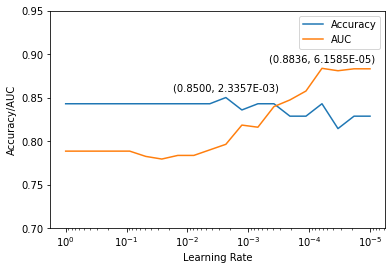

In [ ]:
acc = [y[0] for y in hp_lr_exploration]
auc = [y[1] for y in hp_lr_exploration]

acc_val, acc_idx = max((val, idx) for (idx, val) in enumerate(acc))
auc_val, auc_idx = max((val, idx) for (idx, val) in enumerate(auc))

fig, ax = plt.subplots()
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy/AUC')
ax.set_ylim([0.7, 0.95])
ax.plot(space, acc, label='Accuracy')
ax.annotate(f'({acc_val:.4f}, {space[acc_idx]:.4E})', xy=(space[acc_idx], acc[acc_idx]+0.008), horizontalalignment='center')

ax.plot(space, auc, label='AUC')
ax.annotate(f'({auc_val:.4f}, {space[auc_idx]:.4E})', xy=(space[auc_idx], auc[auc_idx]+0.008), horizontalalignment='center')

ax.legend()
ax.invert_xaxis()

plt.savefig('/content/hp_lr_exploration.pdf')  
#print(f"Best Accuracy {val*100:.2f}% at LR = {space[idx]:.4f}")

##Regularization

###With L1 Regularization

In [ ]:
l1_reg = LogisticRegression(lr=0.000062, reg = 'l1', penalty = 1e-6, threshold=1e-5, verbose=False)
k_crossval(l1_reg, X, y, k=10, scale=True)

Cross val iter 0, Train Accuracy = 0.859375, Validation Accuracy = 0.7857142857142857, AUC = 0.9393939393939394
Cross val iter 1, Train Accuracy = 0.84375, Validation Accuracy = 0.7857142857142857, AUC = 0.9555555555555555
Cross val iter 2, Train Accuracy = 0.875, Validation Accuracy = 0.8571428571428571, AUC = 0.9230769230769231
Cross val iter 3, Train Accuracy = 0.8671875, Validation Accuracy = 0.8571428571428571, AUC = 0.9166666666666667
Cross val iter 4, Train Accuracy = 0.875, Validation Accuracy = 0.7142857142857143, AUC = 0.6363636363636364
Cross val iter 5, Train Accuracy = 0.859375, Validation Accuracy = 0.9285714285714286, AUC = 1.0
Cross val iter 6, Train Accuracy = 0.875, Validation Accuracy = 0.7857142857142857, AUC = 0.7272727272727273
Cross val iter 7, Train Accuracy = 0.859375, Validation Accuracy = 0.9285714285714286, AUC = 0.9230769230769231
Cross val iter 8, Train Accuracy = 0.875, Validation Accuracy = 0.7857142857142857, AUC = 0.9393939393939394
Cross val iter 9, T

[0.8214285714285714, 0.8835800310800311]

####Explore L1 Param

In [ ]:
hp_l1_exploration = []
space = 1/np.geomspace(1, 10000000000, num=11)[::-1]

generate = False
if generate:
  for i in range(len(space)):
    explore = LogisticRegression(lr=0.000062, reg = 'l1', penalty = space[i], threshold=1e-5, verbose=False)
    hp_l1_exploration.append((k_crossval(explore, X, y, k=10, verbose=False, scale=True)))
  np.save('/content/hp_l1_exploration.npy', hp_l1_exploration)
else:
  hp_l1_exploration = np.load('/content/hp_l1_exploration.npy')

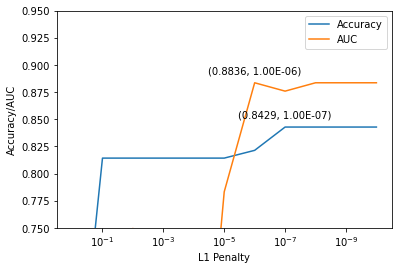

In [ ]:
acc = [y[0] for y in hp_l1_exploration]
auc = [y[1] for y in hp_l1_exploration]

acc_val, acc_idx = max((val, idx) for (idx, val) in enumerate(acc))
auc_val, auc_idx = max((val, idx) for (idx, val) in enumerate(auc))

fig, ax = plt.subplots()
plt.xscale('log')
plt.xlabel('L1 Penalty')
plt.ylabel('Accuracy/AUC')
ax.set_ylim([0.75, 0.95])
ax.plot(space, acc, label='Accuracy')
ax.annotate(f'({acc_val:.4f}, {space[acc_idx]:.2E})', xy=(space[acc_idx], acc[acc_idx]+0.008), horizontalalignment='center')

ax.plot(space, auc, label='AUC')
ax.annotate(f'({auc_val:.4f}, {space[auc_idx]:.2E})', xy=(space[auc_idx], auc[auc_idx]+0.008), horizontalalignment='center')

ax.legend()
ax.invert_xaxis()
plt.savefig('/content/hp_l1_exploration.pdf')  

#print(f"Best Accuracy {val*100:.2f}% at LR = {space[idx]:.4f}")

###With L2 Regularization

In [ ]:
l2_reg = LogisticRegression(lr=0.000062, reg = 'l2', penalty = 1e-4, threshold=1e-5, verbose=False)
k_crossval(l2_reg, X, y, k=10, scale=True)

Cross val iter 0, Train Accuracy = 0.8203125, Validation Accuracy = 0.7857142857142857, AUC = 0.9393939393939394
Cross val iter 1, Train Accuracy = 0.8359375, Validation Accuracy = 0.6428571428571429, AUC = 0.9555555555555555
Cross val iter 2, Train Accuracy = 0.8203125, Validation Accuracy = 0.9285714285714286, AUC = 0.8461538461538461
Cross val iter 3, Train Accuracy = 0.828125, Validation Accuracy = 0.8571428571428571, AUC = 0.875
Cross val iter 4, Train Accuracy = 0.8203125, Validation Accuracy = 0.7857142857142857, AUC = 0.696969696969697
Cross val iter 5, Train Accuracy = 0.8203125, Validation Accuracy = 0.7857142857142857, AUC = 1.0
Cross val iter 6, Train Accuracy = 0.828125, Validation Accuracy = 0.8571428571428571, AUC = 0.8181818181818182
Cross val iter 7, Train Accuracy = 0.8203125, Validation Accuracy = 0.9285714285714286, AUC = 1.0
Cross val iter 8, Train Accuracy = 0.8203125, Validation Accuracy = 0.7857142857142857, AUC = 0.9090909090909091
Cross val iter 9, Train Accur

[0.8214285714285715, 0.8915345765345766]

####Explore L2 Param

In [ ]:
hp_l2_exploration = []
space = 1/np.geomspace(1, 10000000000, num=11)

generate = False
if generate:
  for i in range(len(space)):
    explore = LogisticRegression(lr=0.000062, reg = 'l2', penalty = space[i], threshold=1e-5, verbose=False)
    hp_l2_exploration.append((k_crossval(explore, X, y, k=10, verbose=False, scale=True)))
  np.save('/content/hp_l2_exploration.npy', hp_l2_exploration)
else:
  hp_l2_exploration = np.load('/content/hp_l2_exploration.npy')

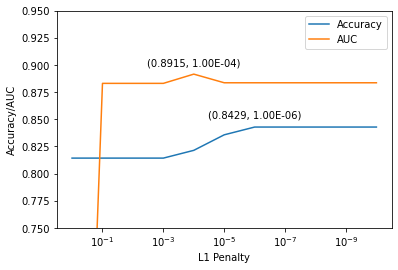

In [ ]:
acc = [y[0] for y in hp_l2_exploration]
auc = [y[1] for y in hp_l2_exploration]

acc_val, acc_idx = max((val, idx) for (idx, val) in enumerate(acc[::-1]))
auc_val, auc_idx = max((val, idx) for (idx, val) in enumerate(auc[::-1]))
acc_idx = len(space) - acc_idx - 1
auc_idx = len(space) - auc_idx - 1

fig, ax = plt.subplots()
plt.xscale('log')
plt.xlabel('L1 Penalty')
plt.ylabel('Accuracy/AUC')
ax.set_ylim([0.75, 0.95])
ax.plot(space, acc, label='Accuracy')
ax.annotate(f'({acc_val:.4f}, {space[acc_idx]:.2E})', xy=(space[acc_idx], acc[acc_idx]+0.008), horizontalalignment='center')

ax.plot(space, auc, label='AUC')
ax.annotate(f'({auc_val:.4f}, {space[auc_idx]:.2E})', xy=(space[auc_idx], auc[auc_idx]+0.008), horizontalalignment='center')

ax.legend()
ax.invert_xaxis()
plt.savefig('/content/hp_l2_exploration.pdf')  


#print(f"Best Accuracy {val*100:.2f}% at LR = {space[idx]:.4f}")

## With Learning Rate Decay




In [ ]:
lr_decay = LogisticRegression(lr=0.1, lr_decay=0.00001, niter = 100000, verbose=False)
k_crossval(lr_decay, X, y, k=10)

Cross val iter 0, Train Accuracy = 0.890625, Validation Accuracy = 0.7857142857142857, AUC = 0.8484848484848485
Cross val iter 1, Train Accuracy = 0.890625, Validation Accuracy = 0.7142857142857143, AUC = 0.9777777777777779
Cross val iter 2, Train Accuracy = 0.890625, Validation Accuracy = 0.7857142857142857, AUC = 0.8461538461538461
Cross val iter 3, Train Accuracy = 0.890625, Validation Accuracy = 0.9285714285714286, AUC = 0.75
Cross val iter 4, Train Accuracy = 0.90625, Validation Accuracy = 0.7142857142857143, AUC = 0.5757575757575758
Cross val iter 5, Train Accuracy = 0.890625, Validation Accuracy = 1.0, AUC = 1.0
Cross val iter 6, Train Accuracy = 0.90625, Validation Accuracy = 0.7857142857142857, AUC = 0.787878787878788
Cross val iter 7, Train Accuracy = 0.8984375, Validation Accuracy = 0.9285714285714286, AUC = 1.0
Cross val iter 8, Train Accuracy = 0.8984375, Validation Accuracy = 0.8571428571428571, AUC = 0.8787878787878788
Cross val iter 9, Train Accuracy = 0.890625, Validat

0.8357142857142857

## With Learning Rate Decay (step wise)

In [ ]:
lr_decay_step = LogisticRegression(lr=0.0001, lr_schedule='step', interval=5000, lr_drop=0.777778, reg = 'l2', penalty = 1e-4, threshold=1e-5, verbose=False)
k_crossval(lr_decay_step, X, y, k=10, scale=True)

####Explore LR Decay


In [ ]:
hp_lr_decay_exploration = []
space = np.linspace(0, 1, num=10)
#space = np.append(space, np.linspace(0.80, 0.95, num=15))
#space = np.sort(space)[::-1]

generate = False
if generate:
  for i in range(len(space)):
    explore = LogisticRegression(lr=0.0001, lr_schedule='step', interval=5000, lr_drop=space[i], reg = 'l2', penalty = 1e-4, threshold=1e-5, verbose=False)
    hp_lr_decay_exploration.append((k_crossval(explore, X, y, k=10, verbose=False, scale=True)))
  np.save('/content/hp_lr_decay_exploration.npy', hp_lr_decay_exploration)
else:
  hp_lr_decay_exploration = np.load('/content/hp_lr_decay_exploration.npy')

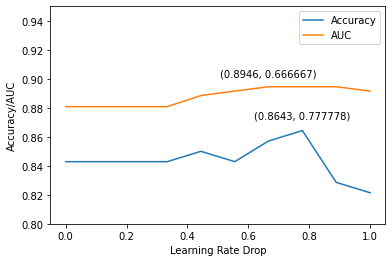

In [ ]:
acc = [y[0] for y in hp_lr_decay_exploration]
auc = [y[1] for y in hp_lr_decay_exploration]

acc_val, acc_idx = max((val, idx) for (idx, val) in enumerate(acc[::-1]))
auc_val, auc_idx = max((val, idx) for (idx, val) in enumerate(auc[::-1]))
acc_idx = len(space) - acc_idx - 1
auc_idx = len(space) - auc_idx - 1


fig, ax = plt.subplots()
plt.xlabel('Learning Rate Drop')
plt.ylabel('Accuracy/AUC')
ax.set_ylim([0.8, 0.95])
ax.plot(space, acc, label='Accuracy')
ax.annotate(f'({acc_val:.4f}, {space[acc_idx]:.6f})', xy=(space[acc_idx], acc[acc_idx]+0.008), horizontalalignment='center')

ax.plot(space, auc, label='AUC')
ax.annotate(f'({auc_val:.4f}, {space[auc_idx]:.6f})', xy=(space[auc_idx], auc[auc_idx]+0.007), horizontalalignment='center')

ax.legend()
plt.savefig('/content/hp_lr_decay_exploration.pdf')  


#print(f"Best Accuracy {val*100:.2f}% at LR = {space[idx]:.4f}")

##Explore Stopping Threshold


In [ ]:
hp_threshold_exploration = []
space = 1/np.geomspace(1, 10000000, num=8)
space = np.append(space, 1/np.geomspace(10000, 1000000, num=12))
space = np.sort(space)[::-1]

generate = True
if generate:
  for i in range(len(space)):
    explore = LogisticRegression(lr=0.0001, lr_schedule='step', interval=5000, lr_drop=0.777778, reg = 'l2', penalty = 1e-4, threshold=space[i], verbose=False)
    hp_threshold_exploration.append((k_crossval(explore, X, y, k=10, verbose=False, scale=True)))
  np.save('/content/hp_threshold_exploration.npy', hp_threshold_exploration)
else:
  hp_threshold_exploration = np.load('/content/hp_threshold_exploration.npy')

Mean over 10 folds: Validation Accuracy  = 0.18571428571428575, AUC = 0.49999999999999994
Mean over 10 folds: Validation Accuracy  = 0.8285714285714285, AUC = 0.8830341880341881
Mean over 10 folds: Validation Accuracy  = 0.8285714285714285, AUC = 0.8830341880341881
Mean over 10 folds: Validation Accuracy  = 0.8285714285714285, AUC = 0.8830341880341881
Mean over 10 folds: Validation Accuracy  = 0.8285714285714285, AUC = 0.8830341880341881
Mean over 10 folds: Validation Accuracy  = 0.8285714285714285, AUC = 0.8830341880341881
Mean over 10 folds: Validation Accuracy  = 0.8285714285714285, AUC = 0.8830341880341881
Mean over 10 folds: Validation Accuracy  = 0.8285714285714285, AUC = 0.8830341880341881
Mean over 10 folds: Validation Accuracy  = 0.8357142857142856, AUC = 0.8808119658119659
Mean over 10 folds: Validation Accuracy  = 0.842857142857143, AUC = 0.8915345765345766
Mean over 10 folds: Validation Accuracy  = 0.8571428571428572, AUC = 0.8915345765345766
Mean over 10 folds: Validation 

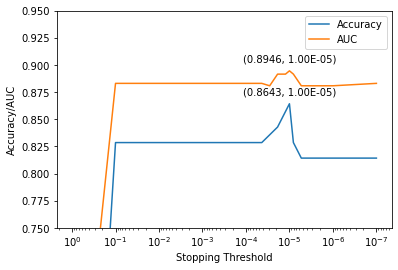

In [ ]:
acc = [y[0] for y in hp_threshold_exploration]
auc = [y[1] for y in hp_threshold_exploration]


acc_val, acc_idx = max((val, idx) for (idx, val) in enumerate(acc[::-1]))
auc_val, auc_idx = max((val, idx) for (idx, val) in enumerate(auc[::-1]))
acc_idx = len(space) - acc_idx - 1
auc_idx = len(space) - auc_idx - 1

fig, ax = plt.subplots()
plt.xscale('log')
plt.xlabel('Stopping Threshold')
plt.ylabel('Accuracy/AUC')
ax.set_ylim([0.75, 0.95])
ax.plot(space, acc, label='Accuracy')
ax.annotate(f'({acc_val:.4f}, {space[acc_idx]:.2E})', xy=(space[acc_idx], acc[acc_idx]+0.008), horizontalalignment='center')

ax.plot(space, auc, label='AUC')
ax.annotate(f'({auc_val:.4f}, {space[auc_idx]:.2E})', xy=(space[auc_idx], auc[auc_idx]+0.008), horizontalalignment='center')

ax.legend()
ax.invert_xaxis()
plt.savefig('/content/hp_threshold_exploration.pdf')  

#print(f"Best Accuracy {val*100:.2f}% at LR = {space[idx]:.4f}")

#Bankrupcy Dataset

###Load Data

In [ ]:
bk_correlation_matrix = bk_data[:-1].corr()
bk_drop_features = cor_featurelist(bk_correlation_matrix)
bk_data.drop(labels=bk_drop_features, axis=1, inplace=True)

bk_data_array = np.array(bk_data.values)

X = bk_data_array[:,:-1]
y = bk_data_array[:,-1]

X_23 = np.concatenate((X, X**2, X**3), axis=1)

###Basic Model

In [ ]:
basic = LogisticRegression(lr=0.02, threshold=1e-5, verbose=False)
k_crossval(basic, X, y, k=10, scale=False)

Cross val iter 0, Train Accuracy = 0.821078431372549, Validation Accuracy = 0.7333333333333333, AUC = 0.7896825396825398
Cross val iter 1, Train Accuracy = 0.8186274509803921, Validation Accuracy = 0.7555555555555555, AUC = 0.8221343873517787
Cross val iter 2, Train Accuracy = 0.8186274509803921, Validation Accuracy = 0.7333333333333333, AUC = 0.7786561264822134
Cross val iter 3, Train Accuracy = 0.8088235294117647, Validation Accuracy = 0.8222222222222222, AUC = 0.8517786561264823
Cross val iter 4, Train Accuracy = 0.8088235294117647, Validation Accuracy = 0.7777777777777778, AUC = 0.834051724137931
Cross val iter 5, Train Accuracy = 0.803921568627451, Validation Accuracy = 0.8666666666666667, AUC = 0.9432773109243697
Cross val iter 6, Train Accuracy = 0.8308823529411765, Validation Accuracy = 0.6888888888888889, AUC = 0.7569169960474309
Cross val iter 7, Train Accuracy = 0.8088235294117647, Validation Accuracy = 0.7333333333333333, AUC = 0.8076923076923077
Cross val iter 8, Train Acc

[0.7755555555555556, 0.8374489643586754]

###Higher Order Features

In [ ]:
basic = LogisticRegression(lr=0.02, threshold=1e-5, verbose=False)
k_crossval(basic, X_23, y, k=10, scale=False)

Cross val iter 0, Train Accuracy = 0.8946078431372549, Validation Accuracy = 0.7111111111111111, AUC = 0.8134920634920635
Cross val iter 1, Train Accuracy = 0.8823529411764706, Validation Accuracy = 0.7555555555555555, AUC = 0.8201581027667985
Cross val iter 2, Train Accuracy = 0.8872549019607843, Validation Accuracy = 0.8222222222222222, AUC = 0.8142292490118577
Cross val iter 3, Train Accuracy = 0.8848039215686274, Validation Accuracy = 0.7777777777777778, AUC = 0.8695652173913044
Cross val iter 4, Train Accuracy = 0.8872549019607843, Validation Accuracy = 0.8666666666666667, AUC = 0.8965517241379309
Cross val iter 5, Train Accuracy = 0.8872549019607843, Validation Accuracy = 0.8, AUC = 0.8466386554621849
Cross val iter 6, Train Accuracy = 0.9019607843137255, Validation Accuracy = 0.7111111111111111, AUC = 0.7005928853754941
Cross val iter 7, Train Accuracy = 0.8921568627450981, Validation Accuracy = 0.8222222222222222, AUC = 0.8056680161943319
Cross val iter 8, Train Accuracy = 0.88

[0.791111111111111, 0.8387584172941277]

####Explore Learning Rate

In [ ]:
bk_lr_exploration = []
space = 1/np.geomspace(1, 1000, num=10)

generate = False
if generate:
  for i in range(len(space)):
    explore = LogisticRegression(lr=space[i], threshold=1e-5, verbose=False)
    bk_lr_exploration.append((k_crossval(explore, X_23, y, k=10, verbose=False, scale=False)))
  np.save('/content/bk_lr_exploration.npy', bk_lr_exploration)
else:
  bk_lr_exploration = np.load('/content/bk_lr_exploration.npy')

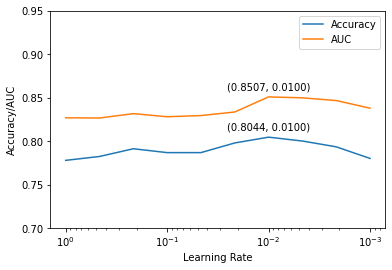

In [ ]:
acc = [y[0] for y in bk_lr_exploration]
auc = [y[1] for y in bk_lr_exploration]

acc_val, acc_idx = max((val, idx) for (idx, val) in enumerate(acc))
auc_val, auc_idx = max((val, idx) for (idx, val) in enumerate(auc))

fig, ax = plt.subplots()
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy/AUC')
ax.set_ylim([0.7, 0.95])
ax.plot(space, acc, label='Accuracy')
ax.annotate(f'({acc_val:.4f}, {space[acc_idx]:.4f})', xy=(space[acc_idx], acc[acc_idx]+0.008), horizontalalignment='center')

ax.plot(space, auc, label='AUC')
ax.annotate(f'({auc_val:.4f}, {space[auc_idx]:.4f})', xy=(space[auc_idx], auc[auc_idx]+0.008), horizontalalignment='center')

ax.legend()
ax.invert_xaxis()
plt.savefig('/content/bk_lr_exploration.pdf')  

#print(f"Best Accuracy {val*100:.2f}% at LR = {space[idx]:.4f}")

## Regularization

###With L1 Regularization

In [ ]:
l1_reg = LogisticRegression(lr=0.01, reg = 'l1', penalty = 1e-5, threshold=1e-5, verbose=False)
k_crossval(l1_reg, X_23, y, k=10, scale=False)

Cross val iter 0, Train Accuracy = 0.8872549019607843, Validation Accuracy = 0.7777777777777778, AUC = 0.878968253968254
Cross val iter 1, Train Accuracy = 0.8823529411764706, Validation Accuracy = 0.7555555555555555, AUC = 0.8379446640316205
Cross val iter 2, Train Accuracy = 0.8872549019607843, Validation Accuracy = 0.8444444444444444, AUC = 0.8102766798418973
Cross val iter 3, Train Accuracy = 0.875, Validation Accuracy = 0.8444444444444444, AUC = 0.8814229249011858
Cross val iter 4, Train Accuracy = 0.8725490196078431, Validation Accuracy = 0.8444444444444444, AUC = 0.9439655172413793
Cross val iter 5, Train Accuracy = 0.8725490196078431, Validation Accuracy = 0.8444444444444444, AUC = 0.9054621848739496
Cross val iter 6, Train Accuracy = 0.8872549019607843, Validation Accuracy = 0.7555555555555555, AUC = 0.7391304347826086
Cross val iter 7, Train Accuracy = 0.8799019607843137, Validation Accuracy = 0.8, AUC = 0.8218623481781375
Cross val iter 8, Train Accuracy = 0.875, Validation 

[0.8133333333333332, 0.8664182805389883]

####Explore L1 Param

In [ ]:
bk_l1_exploration = []
space = 1/np.geomspace(1, 10000000, num=8)
#space = np.append(space, 1/np.geomspace(1000, 100000, num=12))
#space = np.sort(space)[::-1]

generate = False
if generate:
  for i in range(len(space)):
    explore = LogisticRegression(lr=0.01, reg = 'l1', penalty = space[i], threshold=1e-5, verbose=False)
    bk_l1_exploration.append((k_crossval(explore, X_23, y, k=10, verbose=False, scale=False)))
  np.save('/content/bk_l1_exploration.npy', bk_l1_exploration)
else:
  bk_l1_exploration = np.load('/content/bk_l1_exploration.npy')

Mean over 10 folds: Validation Accuracy  = 0.5955555555555556, AUC = 0.5902937550531021
Mean over 10 folds: Validation Accuracy  = 0.5555555555555556, AUC = 0.5325610423280198
Mean over 10 folds: Validation Accuracy  = 0.548888888888889, AUC = 0.6175242714225776
Mean over 10 folds: Validation Accuracy  = 0.6288888888888888, AUC = 0.7512425237943882
Mean over 10 folds: Validation Accuracy  = 0.7844444444444444, AUC = 0.8445315810739761
Mean over 10 folds: Validation Accuracy  = 0.8088888888888888, AUC = 0.8601088791582987
Mean over 10 folds: Validation Accuracy  = 0.8044444444444444, AUC = 0.8519482443918237
Mean over 10 folds: Validation Accuracy  = 0.8044444444444443, AUC = 0.8509457576337305


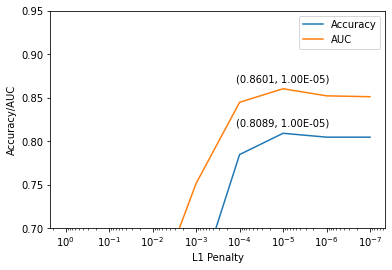

In [ ]:
 acc = [y[0] for y in bk_l1_exploration]
auc = [y[1] for y in bk_l1_exploration]

acc_val, acc_idx = max((val, idx) for (idx, val) in enumerate(acc))
auc_val, auc_idx = max((val, idx) for (idx, val) in enumerate(auc))

fig, ax = plt.subplots()
plt.xscale('log')
plt.xlabel('L1 Penalty')
plt.ylabel('Accuracy/AUC')
ax.set_ylim([0.7, 0.95])
ax.plot(space, acc, label='Accuracy')
ax.annotate(f'({acc_val:.4f}, {space[acc_idx]:.2E})', xy=(space[acc_idx], acc[acc_idx]+0.008), horizontalalignment='center')

ax.plot(space, auc, label='AUC')
ax.annotate(f'({auc_val:.4f}, {space[auc_idx]:.2E})', xy=(space[auc_idx], auc[auc_idx]+0.008), horizontalalignment='center')

ax.legend()
ax.invert_xaxis()
plt.savefig('/content/bk_l1_exploration.pdf')  

#print(f"Best Accuracy {val*100:.2f}% at LR = {space[idx]:.4f}")


###With L2 Regularization

In [ ]:
l2_reg = LogisticRegression(lr=0.01, reg = 'l2', penalty = 1e-6, threshold=1e-5, verbose=False)
k_crossval(l2_reg, X_23, y, k=10)

Cross val iter 0, Train Accuracy = 0.8725490196078431, Validation Accuracy = 0.7777777777777778, AUC = 0.8571428571428572
Cross val iter 1, Train Accuracy = 0.875, Validation Accuracy = 0.7333333333333333, AUC = 0.8320158102766798
Cross val iter 2, Train Accuracy = 0.8627450980392157, Validation Accuracy = 0.7777777777777778, AUC = 0.7707509881422925
Cross val iter 3, Train Accuracy = 0.8700980392156863, Validation Accuracy = 0.7777777777777778, AUC = 0.8616600790513835
Cross val iter 4, Train Accuracy = 0.8553921568627451, Validation Accuracy = 0.8666666666666667, AUC = 0.9525862068965517
Cross val iter 5, Train Accuracy = 0.8627450980392157, Validation Accuracy = 0.8444444444444444, AUC = 0.8865546218487396
Cross val iter 6, Train Accuracy = 0.8700980392156863, Validation Accuracy = 0.7333333333333333, AUC = 0.7193675889328063
Cross val iter 7, Train Accuracy = 0.875, Validation Accuracy = 0.8, AUC = 0.7874493927125507
Cross val iter 8, Train Accuracy = 0.8651960784313726, Validation

0.791111111111111

####Explore L2 Param

In [ ]:
bk_l2_exploration = []
space = 1/np.geomspace(1, 10000000, num=8)
#space = np.append(space, 1/np.geomspace(10000, 1000000, num=12))
#space = np.sort(space)[::-1]

generate = False
if generate:
  for i in range(len(space)):
    explore = LogisticRegression(lr=0.01, reg = 'l2', penalty = space[i], threshold=1e-5, verbose=False)
    bk_l2_exploration.append((k_crossval(explore, X_23, y, k=10, verbose=False)))
  np.save('/content/bk_l2_exploration.npy', bk_l2_exploration)
else:
  bk_l2_exploration = np.load('/content/bk_l2_exploration.npy')

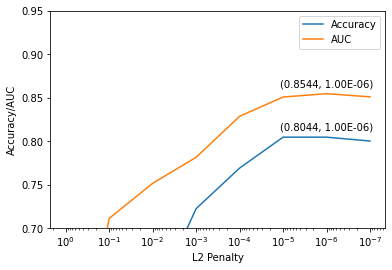

In [ ]:
acc = [y[0] for y in bk_l2_exploration]
auc = [y[1] for y in bk_l2_exploration]

acc_val, acc_idx = max((val, idx) for (idx, val) in enumerate(acc))
auc_val, auc_idx = max((val, idx) for (idx, val) in enumerate(auc))

fig, ax = plt.subplots()
plt.xscale('log')
plt.xlabel('L2 Penalty')
plt.ylabel('Accuracy/AUC')
ax.set_ylim([0.7, 0.95])
ax.plot(space, acc, label='Accuracy')
ax.annotate(f'({acc_val:.4f}, {space[acc_idx]:.2E})', xy=(space[acc_idx], acc[acc_idx]+0.008), horizontalalignment='center')

ax.plot(space, auc, label='AUC')
ax.annotate(f'({auc_val:.4f}, {space[auc_idx]:.2E})', xy=(space[auc_idx], auc[auc_idx]+0.008), horizontalalignment='center')

ax.legend()
ax.invert_xaxis()
plt.savefig('/content/bk_l2_exploration.pdf')  

#print(f"Best Accuracy {val*100:.2f}% at LR = {space[idx]:.4f}")

## With Learning Rate Decay (step wise)

In [ ]:
lr_decay = LogisticRegression(lr=0.05, lr_schedule='step', interval=5000, lr_drop=0.802632, threshold=1e-5, reg = 'l1', penalty = 1e-5, verbose=False)
k_crossval(lr_decay, X_23, y, k=10)

Cross val iter 0, Train Accuracy = 0.8799019607843137, Validation Accuracy = 0.7555555555555555, AUC = 0.886904761904762
Cross val iter 1, Train Accuracy = 0.8651960784313726, Validation Accuracy = 0.7111111111111111, AUC = 0.8517786561264823
Cross val iter 2, Train Accuracy = 0.8848039215686274, Validation Accuracy = 0.7777777777777778, AUC = 0.8043478260869565
Cross val iter 3, Train Accuracy = 0.8725490196078431, Validation Accuracy = 0.8888888888888888, AUC = 0.8873517786561265
Cross val iter 4, Train Accuracy = 0.8553921568627451, Validation Accuracy = 0.8222222222222222, AUC = 0.9245689655172414
Cross val iter 5, Train Accuracy = 0.8627450980392157, Validation Accuracy = 0.8666666666666667, AUC = 0.9600840336134454
Cross val iter 6, Train Accuracy = 0.8799019607843137, Validation Accuracy = 0.7333333333333333, AUC = 0.7608695652173914
Cross val iter 7, Train Accuracy = 0.8676470588235294, Validation Accuracy = 0.8, AUC = 0.8238866396761133
Cross val iter 8, Train Accuracy = 0.877

[0.8044444444444444, 0.8756869149875443]

####Explore LR Decay

In [ ]:
bk_lr_decay_exploration = []
space = np.linspace(0, 1, num=10)
space = np.append(space, np.linspace(0.75, 0.95, num=20))
space = np.sort(space)[::-1]

import sys
np.set_printoptions(threshold=sys.maxsize)

generate = False
if generate:
  for i in range(len(space)):
    explore = LogisticRegression(lr=0.05, lr_schedule='step', interval=5000, lr_drop=space[i], threshold=1e-5, reg = 'l1', penalty = 1e-5, verbose=False)
    bk_lr_decay_exploration.append((k_crossval(explore, X_23, y, k=10, verbose=False)))
  print(bk_lr_decay_exploration)
  np.save('/content/bk_lr_decay_exploration.npy', bk_lr_decay_exploration)
else:
  bk_lr_decay_exploration = np.load('/content/bk_lr_decay_exploration.npy')

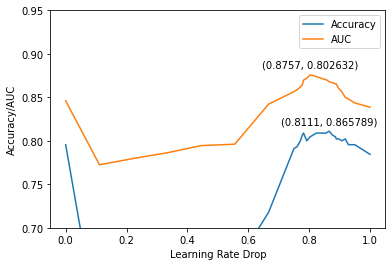

In [ ]:
acc = [y[0] for y in bk_lr_decay_exploration]
auc = [y[1] for y in bk_lr_decay_exploration]

acc_val, acc_idx = max((val, idx) for (idx, val) in enumerate(acc))
auc_val, auc_idx = max((val, idx) for (idx, val) in enumerate(auc))

fig, ax = plt.subplots()
plt.xlabel('Learning Rate Drop')
plt.ylabel('Accuracy/AUC')
ax.set_ylim([0.7, 0.95])
ax.plot(space, acc, label='Accuracy')
ax.annotate(f'({acc_val:.4f}, {space[acc_idx]:.6f})', xy=(space[acc_idx], acc[acc_idx]+0.008), horizontalalignment='center')

ax.plot(space, auc, label='AUC')
ax.annotate(f'({auc_val:.4f}, {space[auc_idx]:.6f})', xy=(space[auc_idx], auc[auc_idx]+0.008), horizontalalignment='center')

ax.legend()
plt.savefig('/content/bk_lr_decay_exploration.pdf')  


#print(f"Best Accuracy {val*100:.2f}% at LR = {space[idx]:.4f}")

##Explore Stopping Threshold


In [ ]:
bk_threshold_exploration = []
space = 1/np.geomspace(1, 10000000, num=8)
generate = False
if generate:
  for i in range(len(space)):
    explore = LogisticRegression(lr=0.05, lr_schedule='step', interval=5000, lr_drop=0.802632, threshold=space[i], reg = 'l1', penalty = 1e-5, verbose=False)
    bk_threshold_exploration.append((k_crossval(explore, X_23, y, k=10, verbose=False)))
  np.save('/content/bk_threshold_exploration.npy', bk_threshold_exploration)
else:
  bk_threshold_exploration = np.load('/content/bk_threshold_exploration.npy')

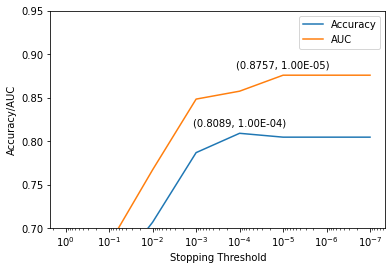

In [ ]:
acc = [y[0] for y in bk_threshold_exploration]
auc = [y[1] for y in bk_threshold_exploration]


acc_val, acc_idx = max((val, idx) for (idx, val) in enumerate(acc[::-1]))
auc_val, auc_idx = max((val, idx) for (idx, val) in enumerate(auc[::-1]))
acc_idx = len(space) - acc_idx - 1
auc_idx = len(space) - auc_idx - 1

fig, ax = plt.subplots()
plt.xscale('log')
plt.xlabel('Stopping Threshold')
plt.ylabel('Accuracy/AUC')
ax.set_ylim([0.7, 0.95])
ax.plot(space, acc, label='Accuracy')
ax.annotate(f'({acc_val:.4f}, {space[acc_idx]:.2E})', xy=(space[acc_idx], acc[acc_idx]+0.008), horizontalalignment='center')

ax.plot(space, auc, label='AUC')
ax.annotate(f'({auc_val:.4f}, {space[auc_idx]:.2E})', xy=(space[auc_idx], auc[auc_idx]+0.008), horizontalalignment='center')

ax.legend()
ax.invert_xaxis()
plt.savefig('/content/bk_threshold_exploration.pdf')  

#print(f"Best Accuracy {val*100:.2f}% at LR = {space[idx]:.4f}")